<center><img src="./pics/Logo.jpeg" alt="ML Arch" width="900" height="400"></center>

# Structural Properties predictions using machine learning models 
# Tutorial:
## Building a model

## Overview
1. Load and examine a dataset in a pandas dataframe
2. Add descriptors to the dataframe using matminer
3. Train, compare, and visualize two machine learning methods with scikit-learn.

In [26]:
import os
import gzip
import json
import pandas as pd
from pymatgen.core import Structure
from IPython.display import display, HTML

# 1. Import Dataset
The data set was stores in a json file to include substructres, but it is imported as a pandas DataFrame

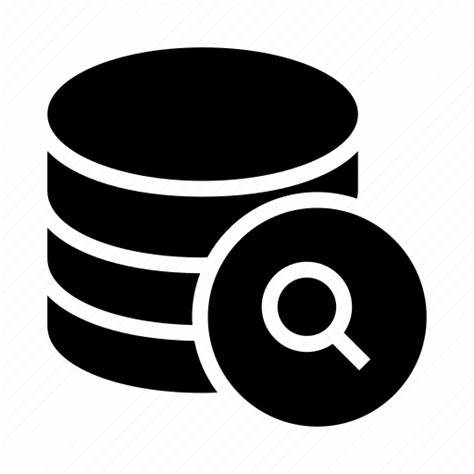

In [27]:
# Open the compressed JSON file
with gzip.open('DataSet.json.gz', 'rt', encoding='utf-8') as file:
    # Read the file contents
    data = file.read()

# Parse the JSON data
data_dict = json.loads(data)

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(data_dict)

# Convert the string representation of Structure objects back to Structure objects
df['structure'] = df['structure'].apply(lambda x: Structure.from_dict(json.loads(x)))

# Now you can work with the DataFrame containing the original data

## 1.1 Data set 
The data set contains straucturalinformation and propeerties of the crystals

In [75]:
df.head()

## 1.2  Data set  statistics

A pandas DataFrame includes a function called ``describe()`` that helps determine statistics for the various numerical columns in the data.

Sometimes, the ``describe()`` function will help to identify mistakes in the data (e.g.negative  bulk modulus).

(``describe()`` function only describes numerical columns by default)



In [76]:
df.describe()

### We want to build a model that is able to predict a target property in the data set 

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter


# choose a target propery 
# shear_modulus is suggested but you can choose eny other property from the data set 
# (i.e. elastic_anisotropy, shear_modulus, poisson_ratio)
# copy and paste one property in the '...'

target_property='...'

# Create figure and axes
fig, axs = plt.subplots(1, figsize=(10, 5))




# Plot 1 - Add your fourth plot here
axs.hist(df[target_property],bins=50)
axs.set_title(target_property, fontsize=16)
axs.set_xlabel(target_property+ 'distribution', fontsize=16)
axs.set_ylabel('Count', fontsize=14)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Using the pandas method describe get the numerical variables of interest 
# then analuyse their correlations using .corr()
# The ideal is to have strong correlation between descriptors and target property and weak correlation 
# between the descriptors 

df.describe().columns

In [3]:
#insert the numerical variable the you want to analyse in data=df[[]] 
#(data must be a dDataFrame object. Use [[...]])

data = df[['...','...']]


# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
# you can now make a plot to see the correlations

from plotnine import ggplot, aes, geom_point, theme_minimal, geom_abline

target_property='...'
# test_feature= '...'
test_feature= '...'

# Create a ggplot object
p = ggplot(data, aes(x='test_feature', y=target_property)) + geom_point() + theme_minimal()
p = p + geom_abline(intercept=0, linetype='dashed', color='red', slope=1)

p.draw()


## 1.3 Data distribution 

Ideally the target property sould have a distribution that allings with the expected statistical distribution

### QQplot 
The purpose of a QQ plot is to visually assess the similarity or deviation between the observed data and the reference distribution. If the observed data closely follows the reference distribution, the points in the QQ plot will lie approximately along a straight line. Deviations from a straight line indicate differences between the observed and theoretical quantiles, suggesting that the observed data may not conform to the reference distribution.

\begin{align*}
Q_{\text{observed}}(p) &= \text{sorted values of the observed data at quantile}\ (p) \\
Q_{\text{theoretical}}(p) &= \text{quantiles of the reference distribution at quantile}\ (p) \\
\end{align*}


The theoretical quantities are the quantiles derived from a chosen reference distribution. The reference distribution is typically a well-known distribution, such as the standard normal distribution (mean = 0, standard deviation = 1). The theoretical quantiles represent the expected values based on the reference distribution and are plotted on the y-axis of the QQ plot.




In [5]:
import matplotlib.pyplot as plt
import statsmodels.api as sm


# Create QQ plots to see if the target property is propertly discributed and compare it with the one of the bulk modulus
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

alternative_target= '...'

# QQ plot for volume
axs[0].set_title('QQ Plot:'+ target_property) 
sm.qqplot(df[target_property], line='s', ax=axs[0])
axs[0].grid(True)

# QQ plot for elastic_anisotropy
axs[1].set_title('QQ Plot:'+alternative_target)
sm.qqplot(df[alternative_target], line='s', ax=axs[1])
axs[1].grid(True)


# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()


# 2. Add descriptors to the data ("featurization")

We are seeking to find relationships between the inputs target_property. To find such relations, we need to modify the input data in a way that that will be numbers that meaningfully represent the underlying physical quantity (features or descriptors).

Examples are standard deviation of the Pauling electronegativity of the elements in the compound (weighted by stoichiometry), or the average coordination number of sites. We use matminer library  to generate possible descriptors from the information available in the data set. 

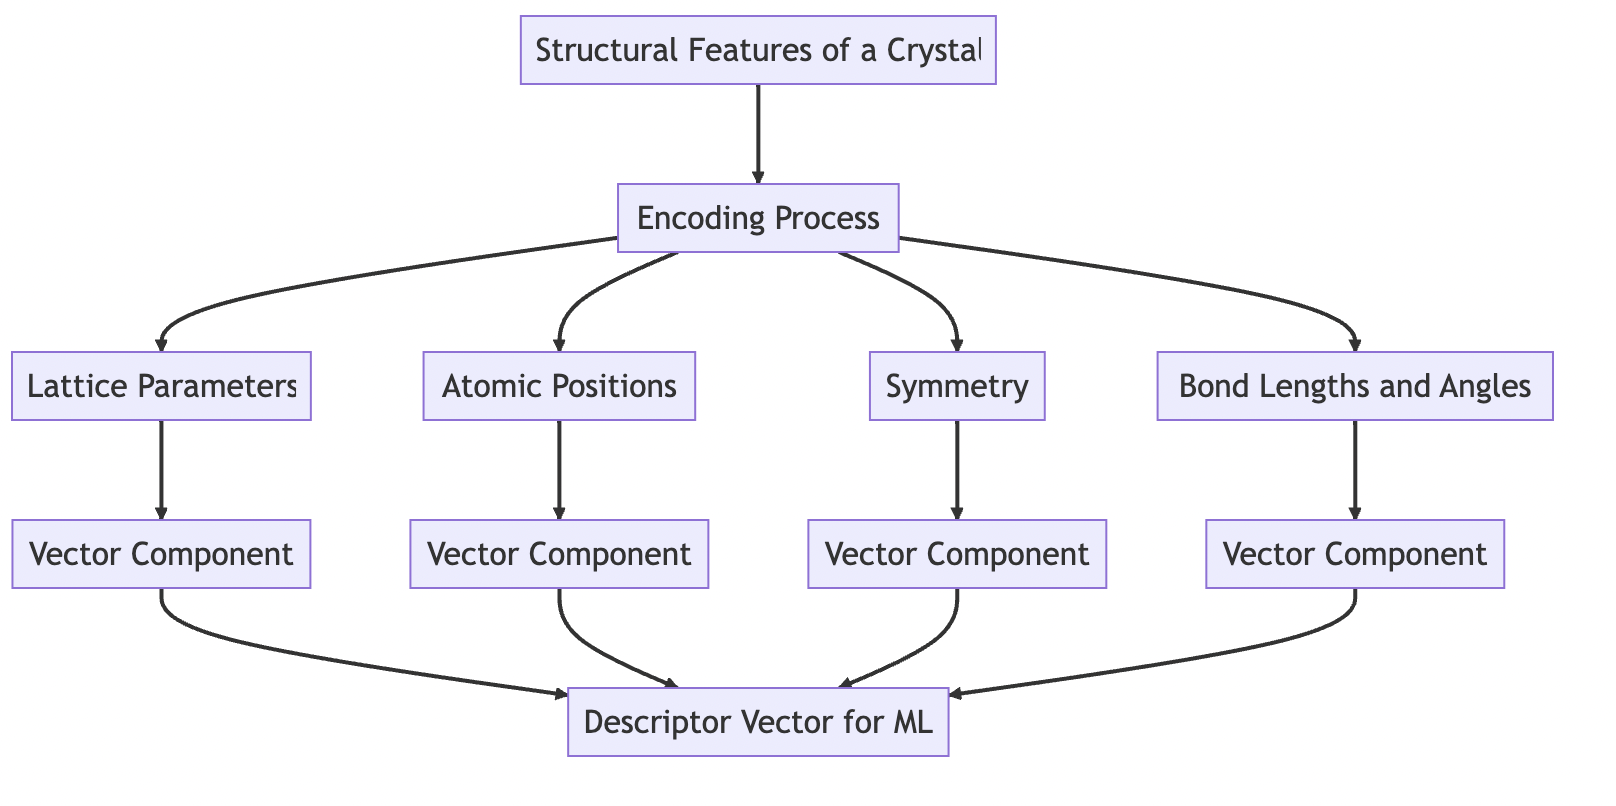

### We will use Magpie featurization, however many possible way to featurize a srtucture exist, and many libraries are currently avalibale.  

## 2.1 Composition-based features

###  Composition: 
This featurizer can generate a variable number of features depending on the properties you choose to extract for the elements in the composition. Common properties include atomic mass, electronegativity, and atomic radius. You can choose to extract multiple properties for each element, and the number of features will be the number of properties multiplied by the number of elements in the composition.

A major class of featurizers available in matminer uses the chemical composition to featurize the input data. Let's add some composition based features to our DataFrame.

To add features based on the composition there is an intermediate passge to do: extract the comosition from the chemical formula. The first step is to have a column representing the chemical composition as a pymatgen Composition object. One way to do this is to use the conversions Featurizers in matminer to turn a String composition (our ``formula`` column from before) into a pymatgen Composition.

### from matminer.featurizers.composition

There are many many Composition based featurizers available in the ``matminer.featurizers.composition``. Let's try the ``ElementProperty`` featurizer which requires knowing the oxidation state of the various elements in the Composition. 


ElementFraction: Calculates the fraction of each element in a composition.

**ElementProperty**: Calculates elemental properties such as atomic number, atomic radius, and electronegativity.

Stoichiometry: Provides stoichiometric features like the number of elements and the ratio of elements in a composition.

IonProperty: Calculates ionic properties such as ionic radii and oxidation states.

ElementalProperty: Allows customization of specific elemental properties of interest.

ValenceOrbital: Calculates valence orbital properties like atomic s, p, d, and f orbital occupancies.

YangSolidSolution: Calculates Yang solid solution parameters.

CohesiveEnergy: Computes the cohesive energy of a composition.

ElectronegativityDiff featurizer which requires knowing the oxidation state of the various elements in the Composition

In [9]:
from pymatgen.core.composition import Element, Composition
from matminer.featurizers.conversions import StrToComposition  
df = StrToComposition().featurize_dataframe(df, "formula")

In [10]:
df.head()

As you can see, we now have a new Composition column above. The visualization in the DataFrame is not so clear, but the column embeds both the elements *and* the amounts of each element in the composition (not shown).

Next, we'll use one of the featurizers in matminer to add a suite of descriptors to the DataFrame.

In [11]:
# you can choose several featurizer in the composition library (e.g. ElementFraction)

from matminer.featurizers.composition import ElementProperty

#Create a featurizer
ep_feat = ElementProperty.from_preset(preset_name="magpie")
# input the "composition" column to the featurizer
df = ep_feat.featurize_dataframe(df, col_id="composition")  


In [12]:
df.head()

### Using  .feature_labels() you can list the added features
### each featurizer also has a  .citations() function that tells you where to find out more about the Featurizer.

In [13]:
ep_feat.feature_labels()

In [47]:
# ep_feat.citations()


### OxidationStates: 
This featurizer extracts the oxidation states of elements in a material composition. The number of features generated by this featurizer is equal to the number of unique elements in the composition. For each element, it extracts the oxidation state.

In [14]:
from matminer.featurizers.conversions import CompositionToOxidComposition
from matminer.featurizers.composition import OxidationStates

df = CompositionToOxidComposition().featurize_dataframe(df, "composition")

os_feat = OxidationStates()
df = os_feat.featurize_dataframe(df, "composition_oxid")


In [15]:
df.head()

As you can see, the end of our data frame has now has some oxidation state based features!

## 2.2 Structure based features

Not all featurizers operate on compositions. Matminer can also analyze crystal structures and featurize those as well. Let's start by adding some simple density features.

### DensityFeatures: 
This featurizer extracts structural features related to the density of a material. The number of features generated by this featurizer depends on the specific density-related properties you choose to extract. Common features include packing fraction and coordination number.


In [16]:
#inport ordering_param , packing_efficiency (e.g. use packing_efficiency())
from matminer.featurizers.structure import DensityFeatures

df_feat = DensityFeatures()
df = df_feat.featurize_dataframe(df, "structure")  # input the structure column to the featurizer


In [51]:
df.head()

In [52]:
df_feat.feature_labels()

In [53]:
# df_feat.citations()

Structureal features addes ['density', 'vpa', 'packing fraction']

## 2.3 Insight into the feature corelations

In [17]:
df.describe().columns

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the features of interest and test their coreclation. 
#A good descriptor has:
# 1)  high correlaton with the target property
# 2)  low correlation with the other descriptors 

#use df. columns or df.head() and create a list to insert into data (e.g. data=df['desq','des2' ...])

df.describe().columns

In [19]:
# data=df[numerical_columns]
# Calculate the correlation matrix

data =df[['...']]
correlation_matrix = data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.1)
plt.title('Correlation Matrix', fontsize=10)
plt.tight_layout()
plt.show()

Some structure based featurizers that are complex and may require a detailed analysis of the crystal structure

# 3. Machine learning models optimization

We now have enough data to do some machine learning! We'll need to first determine what columns we consider input (independent variables) and what column we consider output (dependent variable).

## 3.1 Neural Network model

We try a Neural Network model first 


<img src="./pics/NN.png" alt="NN" width="300" height="200">

###  3.1.1 Define input data and output data

The exarcises focus on``shear_modulus`` as target property but you can try with any of the crystal property in the data set.

In [62]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [72]:
# This tutorial is prepared to use shaar_modulus but poisson_ratio, elastic_anisotropy, poisson_ratio can also be used 

# target_property='...'
target_property='shear_modulus'

y = df[target_property].values


# We store in X the descriptors and we exclude the target property and the descriptors that are either not numeric or useful 
excluded = ["shear_modulus", "bulk_modulus", "elastic_anisotropy", "formula", "material_id", 
            "poisson_ratio", "structure", "composition", "composition_oxid"]
X = df.drop(excluded, axis=1)

# We divide X and y into train and test set. You can chnage the ratio between the two modifing the value of test_size
# Typically test size is between 0.2 and 0.3 

testsize=0.2 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=1)


# print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))

In [73]:
# Create a neural network model
# Some of the possible choices of activation are sigmoid, tanh 
# The number of layers and nodes my have a strong influence on the optimization convergence 
# input_shape must be equal to the number of examples provided (i.e. length of the training set)


Nnodes1 = 64      # try to change Nnodes1 and Nnodes2
Nnodes2 = 32
ActFunct= 'relu'  # relu, sigmoid, tanh 

model = keras.Sequential([
    layers.Dense(Nnodes1, activation=ActFunct, input_shape=(X_train.shape[1],)),
    layers.Dense(Nnodes2, activation=ActFunct),
    layers.Dense(1)])

### 3.1.2. Optimization

During the optimization of Neural Networks, the weights ($w_i$) are adjusted using the gradient descent algorithm or its variants to minimize the loss function (e.g. MSE). The basic update rule for a weight ($w_i$) in gradient descent is:

\begin{equation}
w_i = w_i - \alpha \frac{\partial L}{\partial w_i}
\end{equation}

\begin{equation}
MSE = {\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
\end{equation}


Where:

$w_i$ is the weight being updated.
$\alpha$ is the learning rate, a hyperparameter that determines the step size during the weight update.
$L$ is the loss function that measures how far the network's predictions are from the actual target values.
$\frac{\partial L}{\partial w_i}$ is the partial derivative of the loss function with respect to the weight $w_i$, also known as the gradient. It indicates how the loss would change with respect to a small change in $w_i$.
This equation represents the basic idea behind the weight update in neural networks. There are also advanced optimization algorithms like Adam, RMSprop, and others that have slightly different update rules, but they are all based on the concept of gradient descent.




In [ ]:
# Compile and train the model
# Some of possible choices are adam, sgd and rmsprop 

# Chect the convergence of the solution with the number of optimization cocles epochs
# Using verbose=1 you can visualise value of the loss function at each cycle 

Nepochs = 10

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=Nepochs, batch_size=32,verbose=1)

**layers.Dense**:  number of layers in the neural network and the number of neurons in each layer. Increasing the number of layers or neurons can increase the model's capacity to learn complex patterns, but it can also lead to overfitting if the model becomes too complex for the available data.

**activation**: activation function used in each layer. Common activation functions include 'relu' (Rectified Linear Unit), 'sigmoid', and 'tanh'. Different activation functions can impact the model's ability to capture non-linear relationships in the data.

**input_shape**: This parameter defines the shape of the input data for the first layer and it must match the number of features in the input data. 

**optimizer**: This parameter determines the optimization algorithm used to update the model's weights during training. Common optimizers include 'adam', 'sgd' (Stochastic Gradient Descent), and 'rmsprop'. Different optimizers have different learning rate schedules and update rules, which can affect the convergence speed and final performance of the model.

**loss**: loss function used to evaluate the model's performance during training. For regression tasks, 'mean_squared_error' is a commonly used loss function. 

**epochs**:  number of times the model will iterate over the entire training dataset during training. Increasing the number of epochs can allow the model to see more examples and potentially improve its performance, but it can also increase the risk of overfitting if the model memorizes the training data.

### 3.1.4. Evaluate the quality of the model 
$ \Huge {R^2 = 1 - \frac{{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}}{{\sum_{i=1}^{n}(y_i - \bar{y})^2}}}$  


$ \Huge RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

# Continue with the evaluation and testing steps
# once the model is optimised, we can use it to predict the value of y give for each crystal (X)


# Evaluate the model on the training set
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)
print('Training R2 = %.3f' % train_r2)
print('Training RMSE = %.3f' % train_rmse)

# Evaluate the model on the test set
test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)
print('Test R2 = %.3f' % test_r2)
print('Test RMSE = %.3f' % test_rmse)


In [21]:
import matplotlib.pyplot as plt

# # let's plot the predicted values vs the "real ones" (e.g. the original values of the target property in the data set)

# Create a figure to contain the subplots
plt.figure(figsize=(12, 5))

# First subplot for training set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(y_train, train_pred, color='blue', label='Training')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Training set - Actual vs Predicted')
plt.legend()

# Second subplot for test set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(y_test, test_pred, color='green', label='Test')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Test set - Actual vs Predicted')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


### 3.1.5 Using yhe Neural Network model make predictions

In [ ]:
# Provide a set of descriptors of a new crystal (or set of crystals) 
#and the model will output the predicted property 

# predictions = model.predict(X_new)

# Display the predictions
# print(predictions)

## 3.2 Random forest model

<img src="./pics/RandomForest.png" alt="RF" width="500" height="400">

Let's try a random forest model and compare the result with neural network results

In [52]:
y = df['bulk_modulus'].values
excluded = ["shear_modulus", "bulk_modulus", "elastic_anisotropy", "formula", "material_id", 
            "poisson_ratio", "structure", "composition", "composition_oxid"]
X = df.drop(excluded, axis=1)
print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
# Nest is the number of decision trees in the random fores

testsize=  # Try different values

Nest=    # Try different values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=1)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=Nest, random_state=1, verbose=1)

**Bootstrap Aggregating (Bagging):**
- Random Forests use a technique called bootstrap aggregating, or bagging, to create different training datasets.
- For each tree, a dataset is created by randomly selecting samples from the original dataset with replacement.

**Feature Randomness:**
- At each split in the decision tree, Random Forests consider a random subset of features rather than all features.
- The number of features considered at each split is controlled by the `max_features` hyperparameter.

**Building Multiple Decision Trees:**
- Random Forests build multiple decision trees using the datasets created through bagging.
- Each tree is built by recursively making binary splits in the dataset.
- The splits are made by minimizing a loss function. For regression, common loss functions are Mean Squared Error (MSE) and Mean Absolute Error (MAE)




In [ ]:
# Fit the model on the training set
rf.fit(X_train, y_train)

**n_estimators**: The number of decision trees in the random forest. Increasing the number of estimators can improve the model's performance but may also increase the computational cost.

**random_state**: The random seed used for randomization during the construction of the random forest. Setting a specific random state ensures reproducibility of the results.

### Evaluate the quality of the model 
<!-- <img src="R2.png" alt="R2" width="300" height="200">
<img src="LossFunctionMSE.png" alt="LossFunctionMSE" width="300" height="200"> -->


$ \Huge {R^2 = 1 - \frac{{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}}{{\sum_{i=1}^{n}(y_i - \bar{y})^2}}}$  

$ \Huge RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$

           

In [22]:
# Make predictions on the training set
y_train_pred = rf.predict(X_train)

# Make predictions on the testing set
y_test_pred = rf.predict(X_test)

# Calculate and print the R2 and RMSE for the training set
print('Training R2 = ' + str(round(r2_score(y_train, y_train_pred), 3)))
print('Training RMSE = %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred)))

# Calculate and print the R2 and RMSE for the testing set
print('Testing R2 = ' + str(round(r2_score(y_test, y_test_pred), 3)))
print('Testing RMSE = %.3f' % np.sqrt(mean_squared_error(y_test, y_test_pred)))

At least on the training data, we have very low RMSE and very high R2 - this is good! But let's see if these numbers hold up on cross-validation.

### 3.2.1 Cross Validation:
A more sofisticated approach  consists into splitting the available data into several folds. The model is trained on a combination of folds and evaluated on the remaining one. This process is repeated multiple times, each time using a different fold as the test set.

<img src="./pics/CrossVal.png" alt="CV" width="500" height="400">

In [23]:
# compute cross validation scores for random forest model
from sklearn.model_selection import cross_val_score

# crossvalscore indicates the number of folds


crossvalscore=2  

# This specifies the evaluation metric to be used during cross-validation
r2_scores = cross_val_score(rf, X, y, scoring='r2', cv=crossvalscore, n_jobs=-1)
scores = cross_val_score(rf, X, y, scoring='neg_mean_squared_error', cv=crossvalscore, n_jobs=-1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]

print('Cross-validation results:')
print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

In [24]:
# Create a figure of the predicted values vs the original values in the data set 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the training data
axes[0].scatter(y_train, y_train_pred, color='blue', label='Training', alpha=0.3)
axes[0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect predictions')
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Training set - Actual vs Predicted')
axes[0].legend()

# Plot the testing data
axes[1].scatter(y_test, y_test_pred, color='green', label='Test', alpha=0.3)
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect predictions')
axes[1].set_xlabel('Actual values')
axes[1].set_ylabel('Predicted values')
axes[1].set_title('Test set - Actual vs Predicted')
axes[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

Visually, this looks a little better but not *that* much better. The random forest did very well in training, but is only a little better than linear regression when we plot the cross-validation error as per above.

You could (optionally) visualize the *training* error by replacing the code ``cross_val_predict(rf, X, y, cv=crossvalidation)`` in the above cell with ``rf.predict(X)``. That would look a lot better, but would not be an accurate representation of your prediction error.

### Using Random Forest models you can evaluate the relevance of each descriptor on the target propeety prediction 
### (The correlation and relevance of a descriptor can sometimes be related)

In [25]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
included = X_train.columns.values
indices = np.argsort(importances)[::-1]

# Select the top 10 features
top_indices = indices[1:3]
top_importances = importances[top_indices]
top_features = included[top_indices]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(top_features, top_importances)
plt.xlabel('Features')
plt.ylabel('Importance (%)')
plt.title('Feature by Importances')
plt.tight_layout()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
